In [1]:
import matplotlib.pyplot as plt
import numpy as np
import verde as vd
import harmonica as hm
import pandas as pd
from pathlib import Path
import tarfile
from io import StringIO
import xarray as xr
import xrft
import pyproj
import pygmt
import euler

import warnings
warnings.filterwarnings("ignore")

## Load data

In [2]:
file_path = Path('../data/derivative-line-data.csv')
data = pd.read_csv(file_path)
coordinates = [data.easting_m.values, data.northing_m.values, data.height_m.values]
data

,longitude,latitude,tfa_nT,height_m,easting_m,northing_m,easting_derivative,northing_derivative,upward_derivative,total_gradient
0,-42.646378,-22.549759,161.74,228.60,-4.397578e+06,-2.372560e+06,0.005194,0.006473,-0.041813,0.042628
1,-42.646393,-22.548859,162.67,220.07,-4.397579e+06,-2.372461e+06,0.005078,0.003774,-0.041533,0.042012
2,-42.646408,-22.547958,163.61,210.92,-4.397581e+06,-2.372360e+06,0.004883,0.001232,-0.040638,0.040949
3,-42.646439,-22.547043,164.55,201.78,-4.397584e+06,-2.372259e+06,0.004648,-0.001002,-0.039111,0.039399
4,-42.646454,-22.546143,164.49,192.33,-4.397586e+06,-2.372159e+06,0.004320,-0.002721,-0.037137,0.037487
...,...,...,...,...,...,...,...,...,...,...
63270,-41.986664,-21.892532,117.10,204.83,-4.329550e+06,-2.299772e+06,-0.009647,-0.024008,-0.003148,0.026065
63271,-41.987457,-21.892517,116.17,214.58,-4.329632e+06,-2.299770e+06,-0.009085,-0.022051,-0.004548,0.024279
63272,-41.988266,-21.892502,116.23,221.89,-4.329715e+06,-2.299768e+06,-0.008008,-0.020157,-0.005810,0.022455
63273,-41.989075,-21.892471,115.30,224.03,-4.329799e+06,-2.299765e+06,-0.006561,-0.018451,-0.006805,0.020732


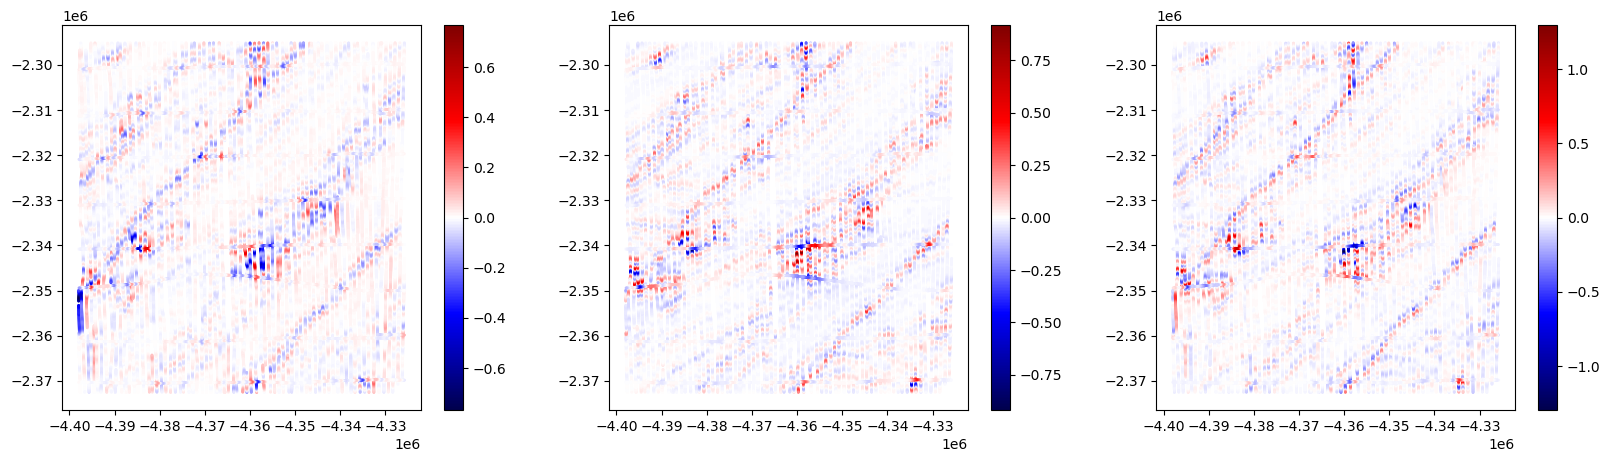

In [3]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
cbar_kwargs = dict(orientation="horizontal", aspect=50, pad=0.015, shrink=0.5)
scale = 400
# data_up.bz.plot.pcolormesh(ax=ax, cmap="gray_r", vmin=-3000, vmax=3000, add_colorbar=False)
axes = axes.ravel()

ax = axes[0]
tmp1 = ax.scatter(
    data.easting_m,
    data.northing_m,
    c=data.easting_derivative,
    s=1,
    cmap="seismic",
    vmin=-vd.maxabs(data.easting_derivative),
    vmax=vd.maxabs(data.easting_derivative),
)
plt.colorbar(tmp1, ax=ax)
ax.set_aspect("equal")

ax = axes[1]
tmp2 = ax.scatter(
    data.easting_m,
    data.northing_m,
    c=data.northing_derivative,
    s=1,
    cmap="seismic",
    vmin=-vd.maxabs(data.northing_derivative),
    vmax=vd.maxabs(data.northing_derivative),
)
plt.colorbar(tmp2, ax=ax)
ax.set_aspect("equal")

ax = axes[2]
tmp3 = ax.scatter(
    data.easting_m,
    data.northing_m,
    c=data.upward_derivative,
    s=1,
    cmap="seismic",
    vmin=-vd.maxabs(data.upward_derivative),
    vmax=vd.maxabs(data.upward_derivative),
)
plt.colorbar(tmp3, ax=ax)
ax.set_aspect("equal")

fig.show()

## Euler Deconvolution

In [4]:
window_size = 10e3
window_step = window_size / 4

In [5]:
%%time
deconvolutions = {}
euler_data = [data.tfa_nT.values, data.easting_derivative.values, data.northing_derivative.values, data.upward_derivative.values]
for si in [1, 2, 3]:
    deconvolutions[si] = euler.EulerDeconvolutionWindowed(
        structural_index=si,
        window_size=window_size,
        window_step=window_step,
        keep=0.2,
    ).fit(coordinates, data=euler_data)

CPU times: user 686 ms, sys: 20.1 ms, total: 706 ms
Wall time: 705 ms


## Euler Inversion

In [20]:
window_size_big = 10e3
window_size_small = 5e3
window_step = 1/4

In [29]:
%%time
ei_big_window = euler.EulerInversionWindowed(
    window_size=window_size_big,
    window_step=window_size_big*window_step,
    keep=0.2,
).fit(
    coordinates,
    data=euler_data,
)
ei_small_window = euler.EulerInversionWindowed(
    window_size=window_size_small,
    window_step=window_size_small*window_step,
    keep=0.05,
).fit(
    coordinates,
    data=euler_data,
)

CPU times: user 2.81 s, sys: 587 ms, total: 3.4 s
Wall time: 30.9 s


In [30]:
all_solutions = ei_big_window.solutions_ + ei_small_window.solutions_

def get_variance(solution):
    return np.sum(np.diag(solution.covariance_)[:3])

all_solutions.sort(key=get_variance)
final_solutions = all_solutions[:int(0.5*len(all_solutions))]
locations = np.transpose([solution.location_ for solution in final_solutions])
base_levels = np.array([solution.base_level_ for solution in final_solutions])
structural_indices = np.array([solution.structural_index for solution in final_solutions])

In [31]:
print(len(ei_big_window.solutions_))
print(len(ei_small_window.solutions_))
print(len(final_solutions))

145
162
153


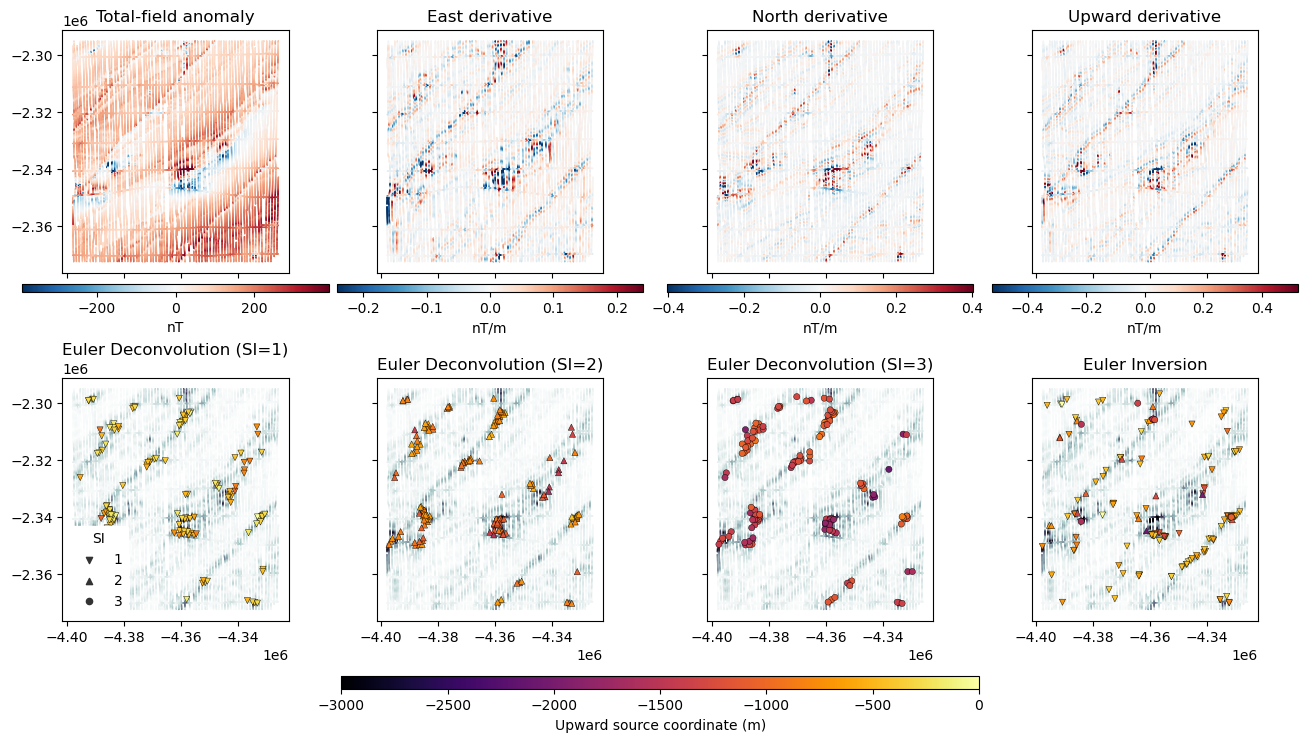

In [32]:
fig, axes = plt.subplots(
    2, 4, figsize=(13, 7.3), layout="constrained", sharey=True, sharex=True
)

subplot_labels = [f"{i})" for i in "abcdefgh"]
units = {
    "tfa_nT": "nT",
    "easting_derivative": "nT/m",
    "northing_derivative": "nT/m",
    "upward_derivative": "nT/m",
}
data_names = {
    "tfa_nT": "Total-field anomaly",
    "easting_derivative": "East derivative",
    "northing_derivative": "North derivative",
    "upward_derivative": "Upward derivative",
}
markers = ["v", "^", "o"]
marker_size = 20
vmin, vmax = -3000, 0
data_size = 1

for field, ax in zip(["tfa_nT", "easting_derivative", "northing_derivative", "upward_derivative"], axes[0, :]):
    ax.set_aspect("equal")
    scale = np.percentile(data[field].values, 99.8)
    scatter = ax.scatter(
        data.easting_m,
        data.northing_m,
        c=data[field].values,
        s=data_size,
        vmin=-scale,
        vmax=scale,
        cmap="RdBu_r",
        edgecolors="none"
    )
    fig.colorbar(
        scatter, ax=ax, orientation="horizontal", aspect=40, pad=0.02, label=units[field]
    )
    ax.set_title(data_names[field])
ax = axes[0, 0]

scale = np.percentile(data['total_gradient'].values, 99.9)
for ax in axes[1, :]:
    ax.set_aspect("equal")
    scatter = ax.scatter(
        data.easting_m,
        data.northing_m,
        c=data['total_gradient'].values,
        s=data_size,
        vmin=0,
        vmax=scale,
        cmap="bone_r",
        edgecolors="none"
    )

# Euler deconvolution
for si, marker, ax in zip([1, 2, 3], markers, axes[1, :-1]):
    ax.set_title(f"Euler Deconvolution (SI={si})")
    ax.scatter(
        *deconvolutions[si].locations_[:2],
        c=deconvolutions[si].locations_[2],
        s=marker_size,
        marker=marker,
        vmin=vmin,
        vmax=vmax,
        edgecolors="black",
        linewidths=0.3,
        cmap="inferno",
    )

# Euler inversion
labels = {}
ax = axes[1, -1]
ax.set_title("Euler Inversion")
for si, marker in zip([1, 2, 3], markers):
    is_si = structural_indices == si
    tmp = ax.scatter(
        *locations[:2, is_si],
        c=locations[2, is_si],
        s=marker_size,
        marker=marker,
        vmin=vmin,
        vmax=vmax,
        edgecolors="black",
        linewidths=0.3,
        cmap="inferno",
    )
    labels[si] = ax.scatter([], [], c="#333333", s=marker_size, marker=marker)

axes[1, 0].legend(
    [labels[si] for si in sorted(labels)],
    sorted(labels),
    loc="lower left",
    framealpha=1,
    facecolor="#ffffff",
    edgecolor="#ffffff",
    title="SI",
)
fig.colorbar(
    tmp,
    ax=axes[1, :],
    aspect=50,
    pad=0.05,
    shrink=0.5,
    orientation="horizontal",
    label="Upward source coordinate (m)",
)

# # Optional: Adding labels, ticks, and titles
# for ax, label in zip(axes.ravel(), subplot_labels):
#     ax.text(-0.05, 1.04, label, transform=ax.transAxes)
# for ax in axes[1, :]:
#     ax.set_xticks(np.arange(0, 61e3, 20e3))
# for ax in axes[:, 0]:
#     ax.set_yticks(np.arange(0, 61e3, 20e3))
# for ax in axes[:, 0]:
#     ax.set_ylabel("Northing (m)")
# for ax in axes[1, :]:
#     ax.set_xlabel("Easting (m)")